# Compling the bacteria dataset

Based on Coleman GA et al. (Science '21). 

[Prev](../00-get-pubdata/240613-1-Coleman-et-al.ipynb): Data download  
[Next](./240615-2-complie-cv.ipynb): Compile CV datasets

In [1]:
import gzip, json
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ete3 import Tree

from colaml import *
from colaml.misc import phyplot, dataplot
from myconfig import DATA_DIR, DATASET_DIR
COLEMAN_DIR = DATA_DIR / 'pubdata' / 'Coleman-et-al-21'

In [2]:
from threadpoolctl import threadpool_limits
threadpool_limits(1, user_api='blas')

## Tree

In [3]:
spptbl = pd.read_csv(COLEMAN_DIR/'SpeciesTable.tsv', sep='\t', index_col=0)
phylum = spptbl['GTDB Taxonomy'].str.split(';', expand=True).set_axis([*'dpcofgs'], axis=1)['p']

In [4]:
spptree398 = Tree(str(COLEMAN_DIR/'SpeciesTrees'/'SpeciesTree_398.nwk'), format=1)
spptree398.ladderize()

spptree527 = Tree(str(COLEMAN_DIR/'SpeciesTrees'/'SpeciesTree_527.nwk'), format=1)
spptree527.ladderize()

spptree528 = Tree(str(COLEMAN_DIR/'SpeciesTrees'/'SpeciesTree_528.nwk'), format=1)
spptree528.ladderize()

265

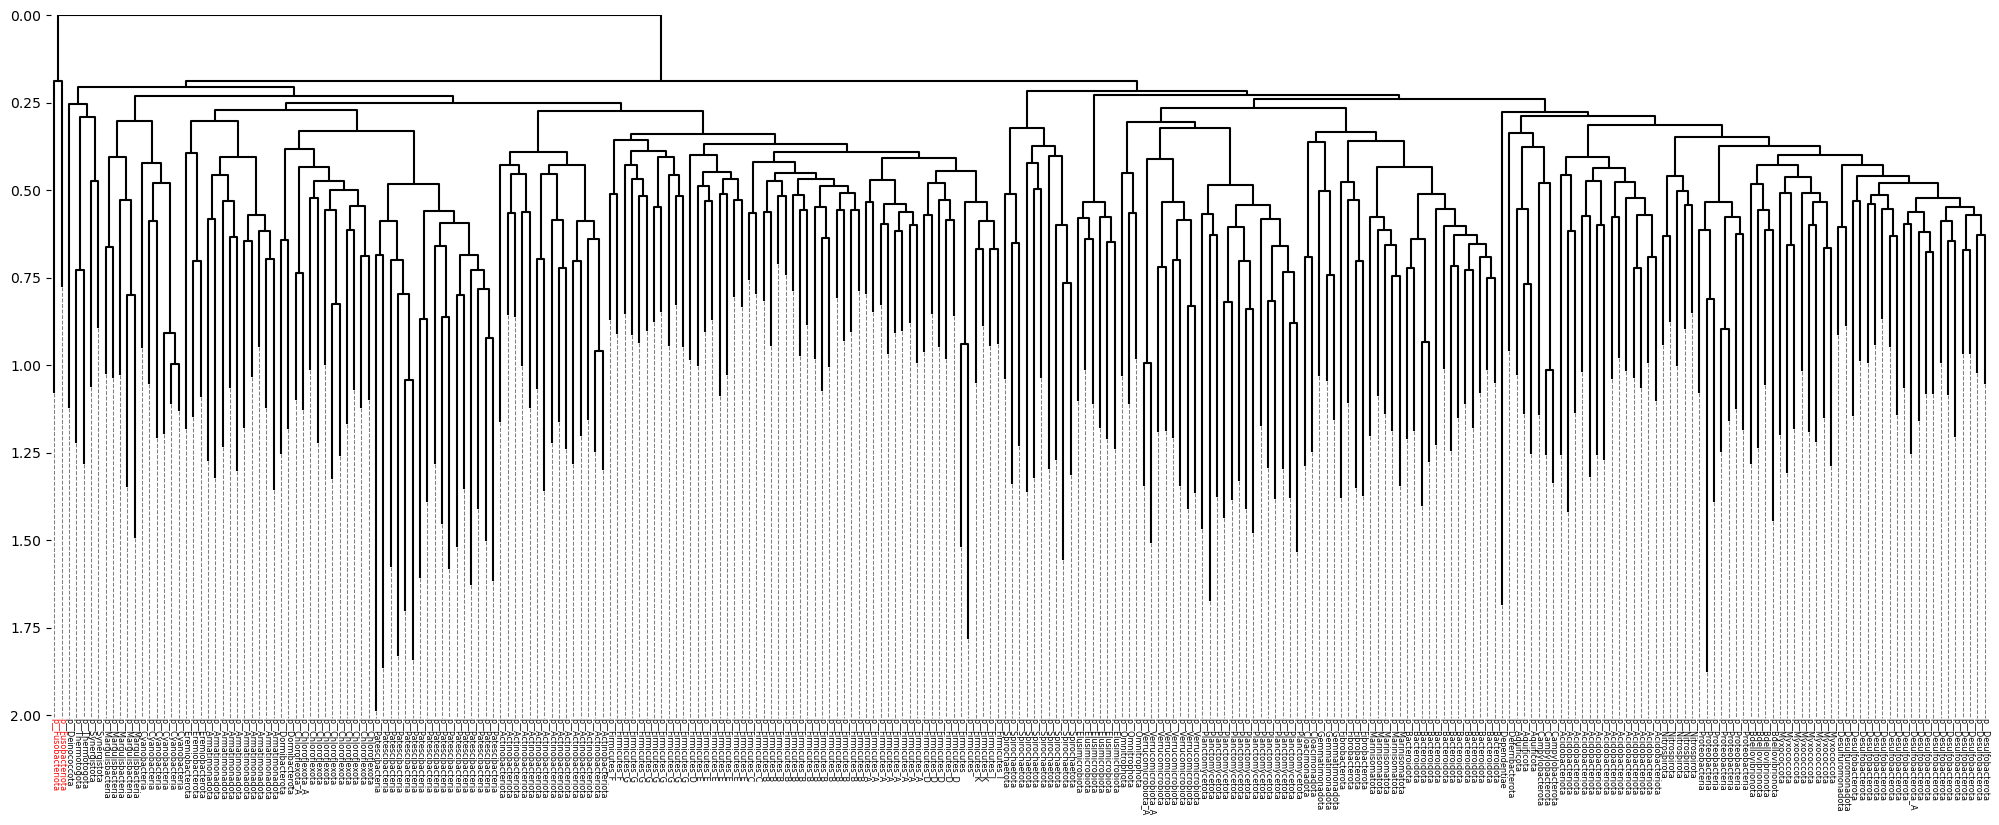

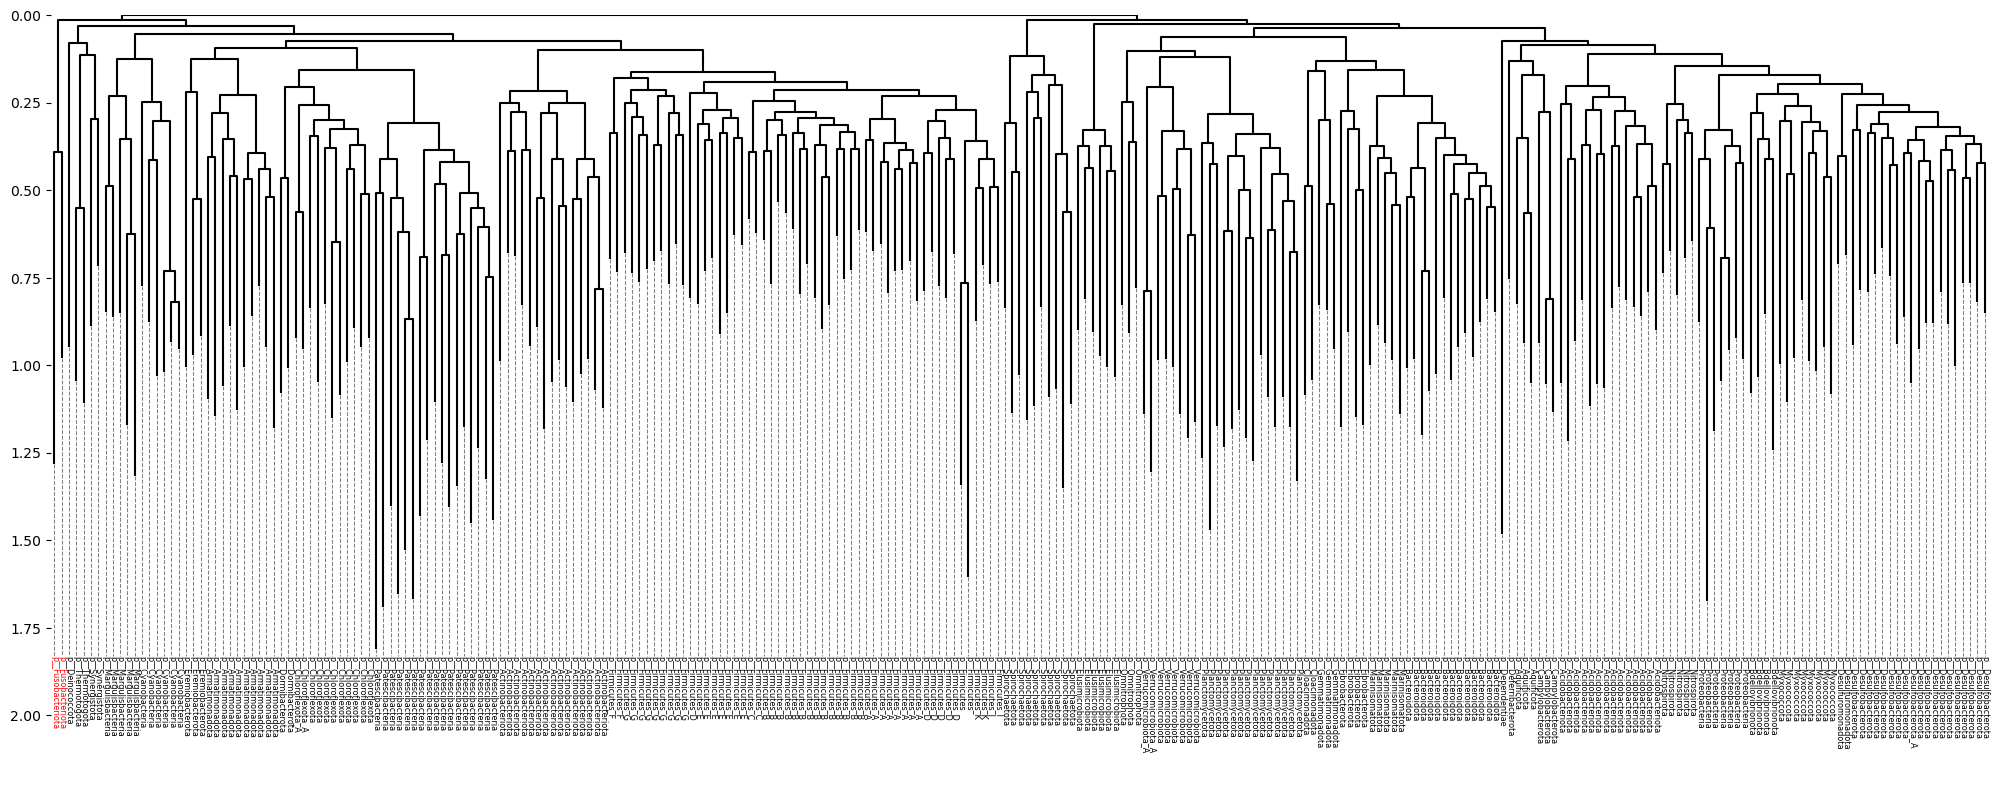

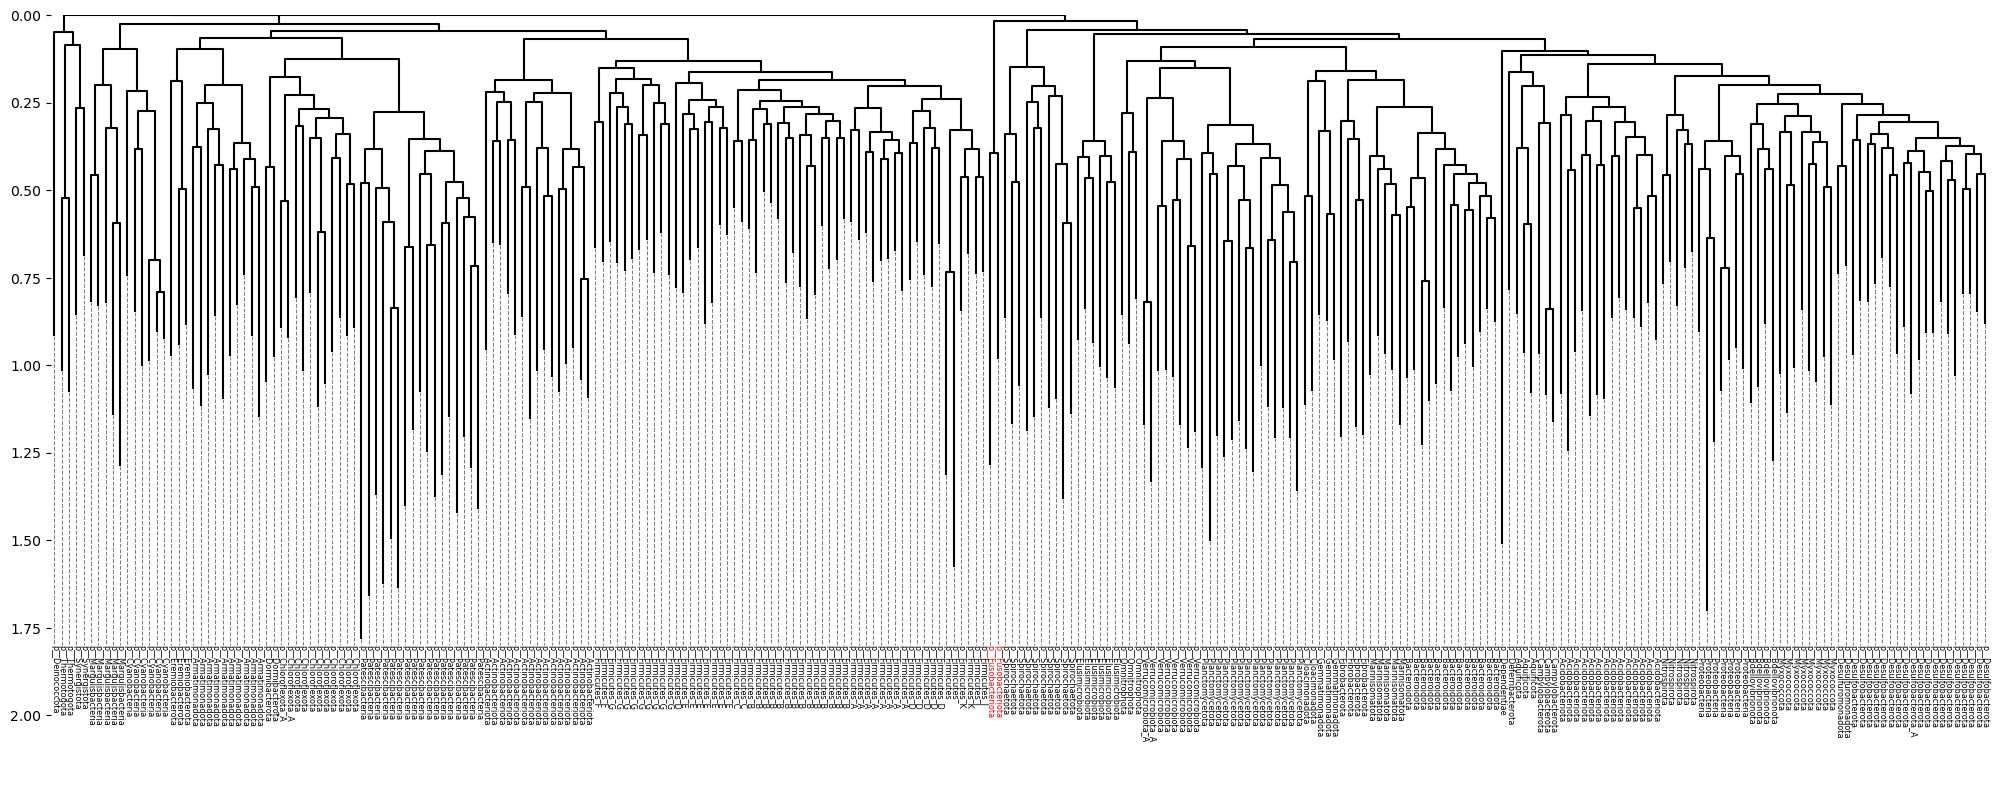

In [5]:
for spptree in (spptree398, spptree527, spptree528):
    fig, ax = plt.subplots(figsize=(25, 10))
    phyplot.draw(
        spptree, show_confidence=False, horizontal=False, align=True, 
        node_text=lambda label: phylum.get(label.name), node_textkw=dict(size='xx-small'), 
        local_node_textkw=lambda label: dict(c='r') if 'Fuso' in phylum.get(label.name) else None, 
        ax=ax
    )
    ax.set_frame_on(False)
    ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
    ax.set_ylim(2.2, 0)

Their analysis left three candidate root positions with different position of Fusobacterium relative to Gracilicutes and Terrabacteria.

Below, as in their subsequent analysis, we adopt the topology placing Fusobacterium as the sister group of Gracilicutes(i.e, the "Root 1" in their article or the "528" tree in figshare).

In [6]:
spptree = spptree528.copy()

for node in spptree.traverse():
    if node.is_leaf():
        continue
    node.name = 'i' + node.name

## COGs

In [7]:
# Extract per-species COG counts from gene trees in the ALE output file.
# There may be a complete list of COG annotations for each gene ID somewhere, 
# but I failed to find it.

cog_counts = {}
for fpath in (COLEMAN_DIR/'COG_ALEs').glob('*.ale'):
    cog, *_ = fpath.name.split('.')
    
    # parse .ale file
    with open(fpath) as file:
        ## skip the '#constructor_string' line
        next(file)
        ## read a gene tree
        gene_tree_str = next(file)
        ## ignore the rest
        
    # extract gene IDs from the tree string
    gene_tree = Tree(gene_tree_str)
    cog_counts[cog] = Counter(name.split('_')[0] for name in gene_tree.get_leaf_names())
    
else:
    cog_counts = pd.DataFrame(cog_counts).fillna(0).astype(int).sort_index(axis=1)
    
display(cog_counts)

,COG0001,COG0002,COG0003,COG0004,COG0005,COG0006,COG0007,COG0009,COG0010,COG0011,...,COG5649,COG5650,COG5652,COG5653,COG5654,COG5658,COG5660,COG5661,COG5662,COG5663
n12,3,1,1,3,2,2,1,1,0,0,...,0,0,0,2,0,0,0,0,0,0
n256,0,1,0,2,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
n257,1,1,0,2,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
n204,1,1,0,2,1,1,2,2,1,0,...,0,0,0,0,0,0,0,0,0,0
n88,2,1,0,3,2,1,2,1,1,0,...,0,0,0,4,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n69,1,1,0,1,1,1,1,1,0,0,...,0,0,0,0,0,2,0,0,0,0
n153,2,2,1,1,2,2,1,1,2,0,...,0,1,0,1,0,0,0,0,1,0
n84,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n7,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Consistent with the number described in their article :)

## Dataset overview 

In [8]:
with pd.option_context('display.max_rows', 20, 'display.min_rows', 20):
    print('max')
    display(cog_counts.max().value_counts().sort_index().cumsum() / cog_counts.shape[1] * 100)
    print()
    print('median')
    display(cog_counts.median().value_counts().sort_index().cumsum() / cog_counts.shape[1] * 100)

max


1      15.020862
2      42.809458
3      61.363004
4      72.406120
5      79.360223
6      84.283727
7      87.315716
8      89.346314
9      91.321280
10     92.433936
         ...    
46     99.666203
48     99.694019
60     99.721836
63     99.777469
64     99.805285
66     99.888734
67     99.916551
83     99.944367
95     99.972184
97    100.000000
Length: 51, dtype: float64


median


0.0     76.968011
1.0     98.831711
2.0    100.000000
dtype: float64

In [9]:
cog_counts

,COG0001,COG0002,COG0003,COG0004,COG0005,COG0006,COG0007,COG0009,COG0010,COG0011,...,COG5649,COG5650,COG5652,COG5653,COG5654,COG5658,COG5660,COG5661,COG5662,COG5663
n12,3,1,1,3,2,2,1,1,0,0,...,0,0,0,2,0,0,0,0,0,0
n256,0,1,0,2,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
n257,1,1,0,2,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
n204,1,1,0,2,1,1,2,2,1,0,...,0,0,0,0,0,0,0,0,0,0
n88,2,1,0,3,2,1,2,1,1,0,...,0,0,0,4,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n69,1,1,0,1,1,1,1,1,0,0,...,0,0,0,0,0,2,0,0,0,0
n153,2,2,1,1,2,2,1,1,2,0,...,0,1,0,1,0,0,0,0,1,0
n84,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n7,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
phytbl = ExtantPhyTable(
    cog_counts.clip(0, 3).T.to_dict(orient='list'), 
    PostorderSerializedTree(spptree)
)

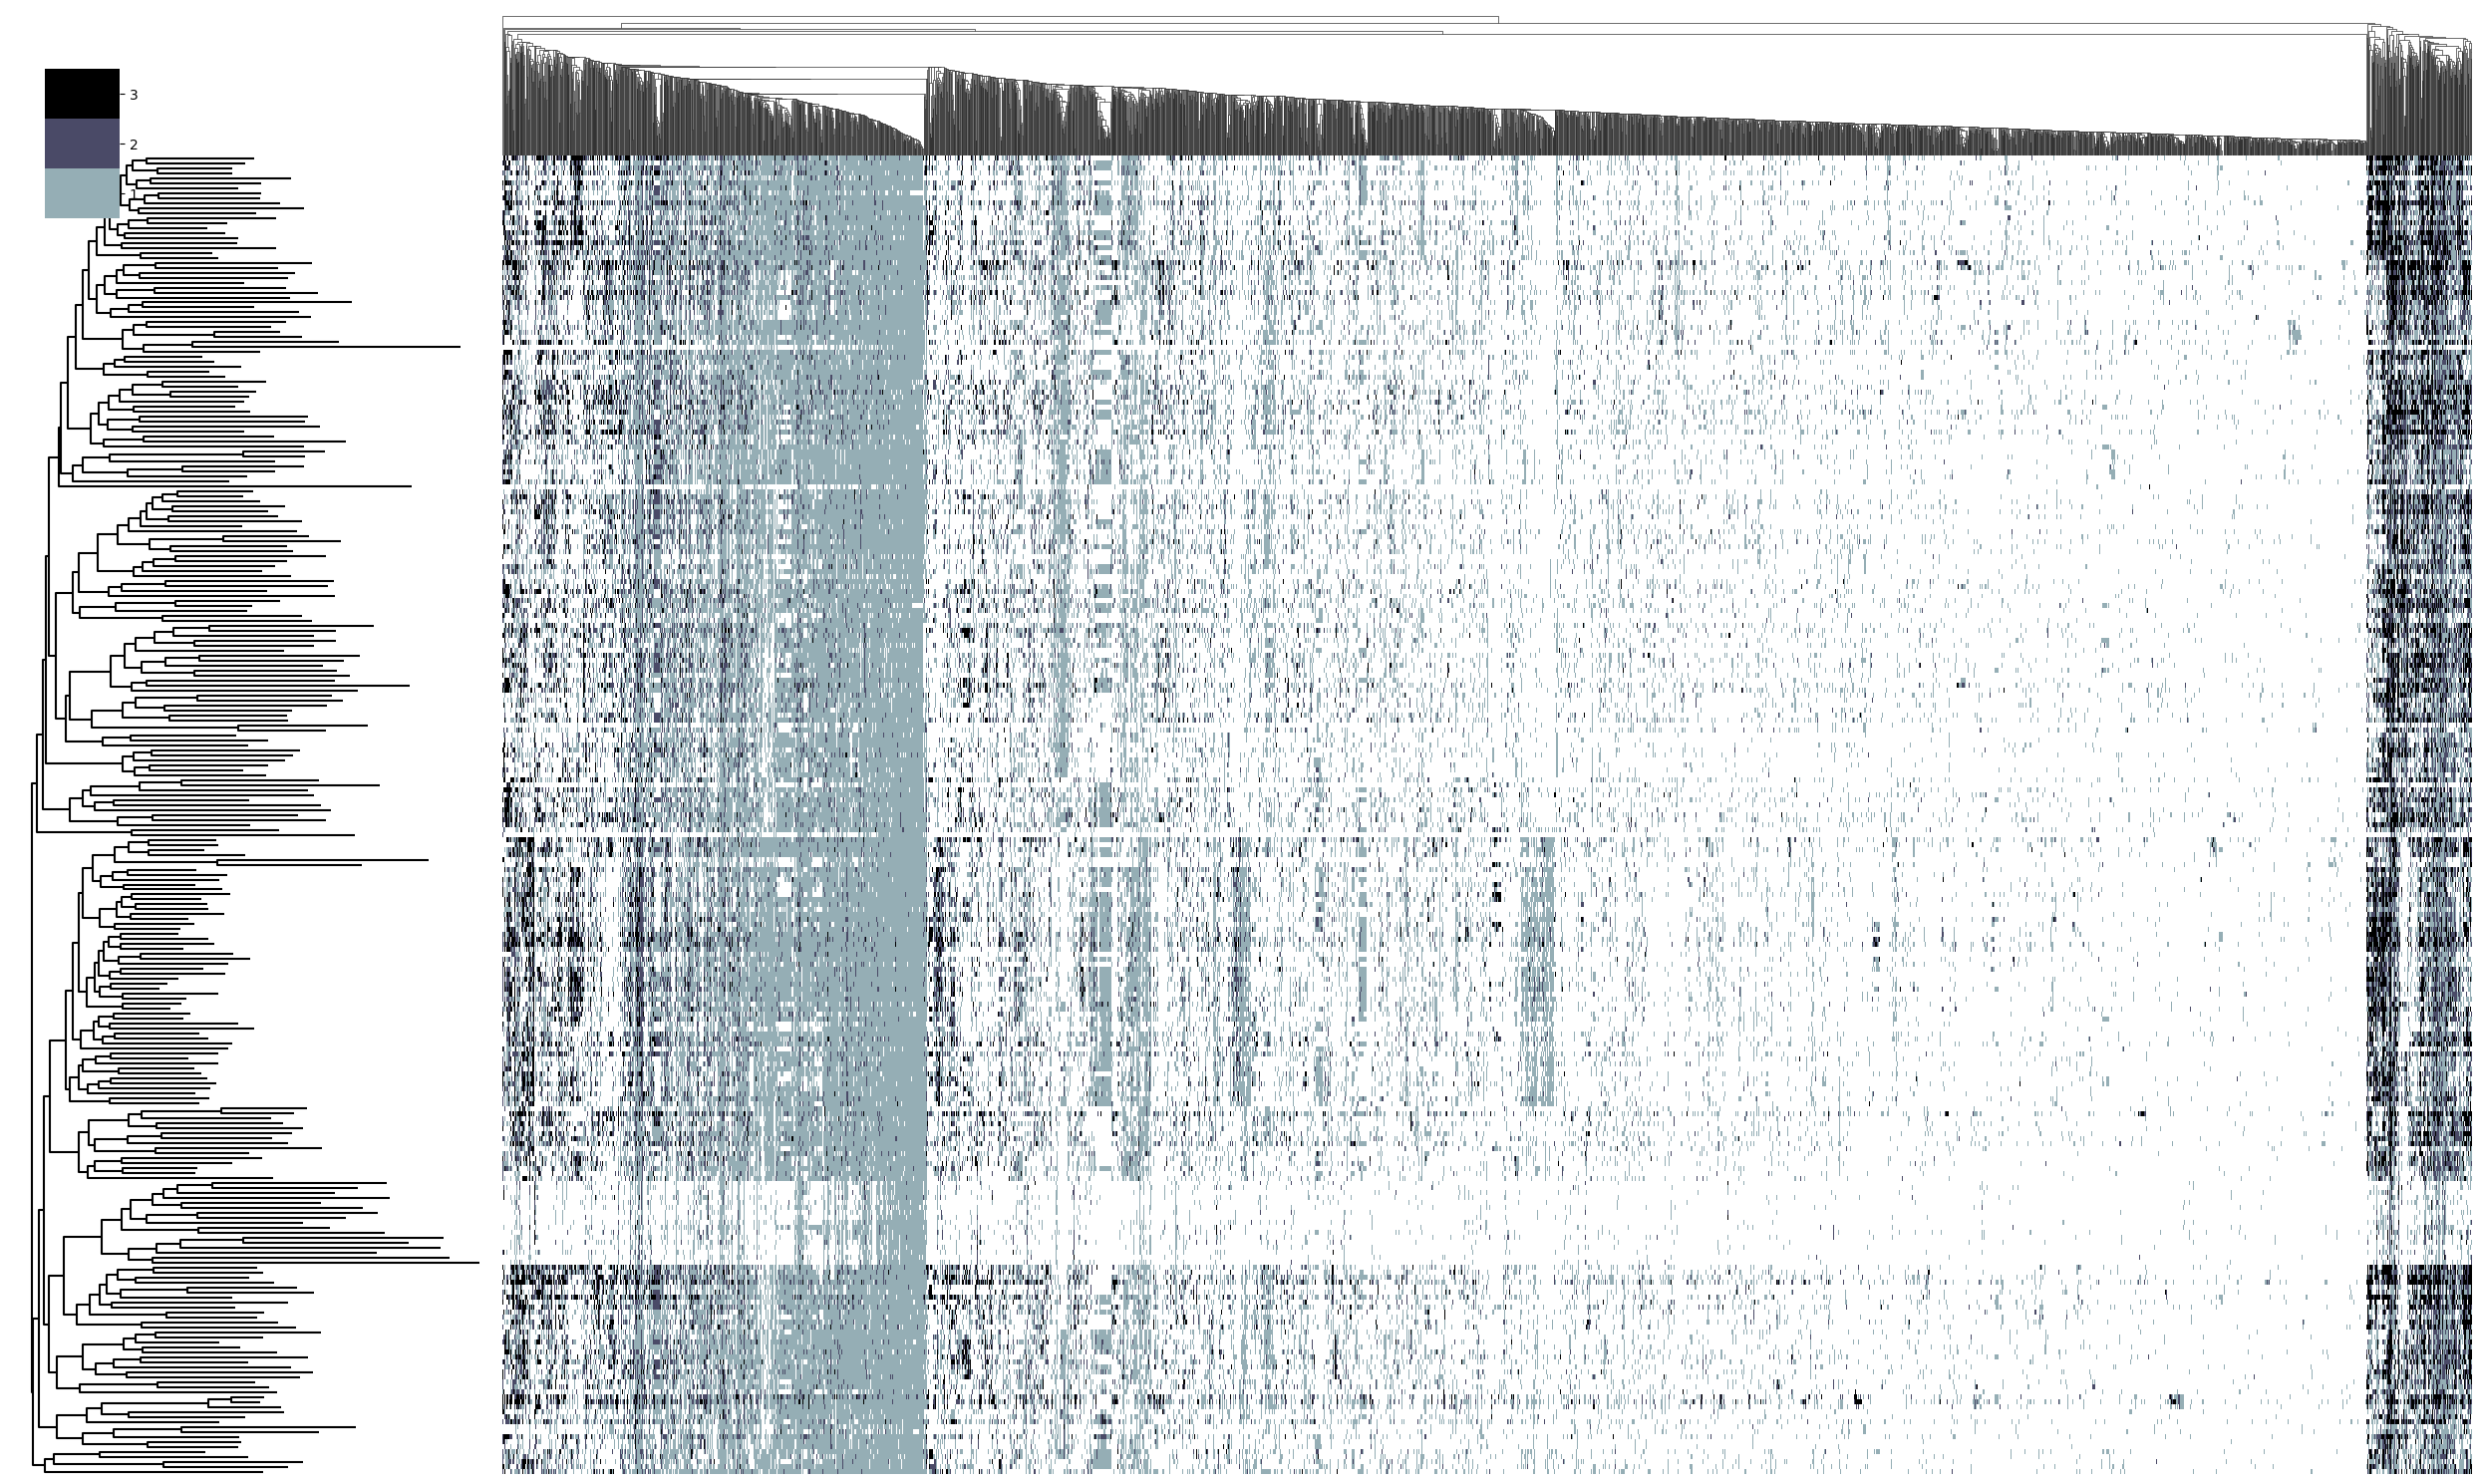

In [11]:
dataplot.draw_extant(phytbl, figsize=(25, 15))

## Save

In [12]:
with gzip.open(DATASET_DIR/'02-bacteria'/'bacteria-main-v0.json.gz', 'wt') as file:
    json.dump({
        'tree': Tree.write(spptree, format=3, format_root_node=True),
        'OGs' : cog_counts.to_dict(orient='split')
    }, file, indent=2)